In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses
from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input
from keras.preprocessing import image_dataset_from_directory, image
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2025-07-16 09:20:17.660741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 09:20:22.857921: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 09:20:25.018725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752657628.932956    5067 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752657629.868682    5067 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752657637.486276    5067 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("obulisainaren/multi-cancer")

print("Path to dataset files:", path)


/home/vscode/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/vscode/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3


In [4]:
BATCH = 16
SIZE = (224,224)

directory = '/home/vscode/.cache/kagglehub/datasets/obulisainaren/multi-cancer/versions/3/Multi Cancer/Multi Cancer'

def data_loading(types, subset):
    print(f"{types}'s {subset} dataset")
    directory1 = directory + "/" + types
    dataset = image_dataset_from_directory(
        directory1,
        labels = "inferred",
        label_mode = "categorical",
        validation_split = 0.2,
        subset = subset,
        shuffle = True,
        seed = 123,
        batch_size = BATCH,
        image_size = SIZE,
    )
    return dataset

brain_dataset_train = data_loading("Brain Cancer", "training")
brain_dataset_val = data_loading("Brain Cancer", "validation")
breast_dataset_train = data_loading("Breast Cancer", "training")
breast_dataset_val = data_loading("Breast Cancer", "validation")
cervical_dataset_train = data_loading("Cervical Cancer", "training")
cervical_dataset_val = data_loading("Cervical Cancer", "validation")
kidney_dataset_train = data_loading("Kidney Cancer", "training")
kidney_dataset_val = data_loading("Kidney Cancer", "validation")
colon_dataset_train = data_loading("Lung and Colon Cancer", "training")
colon_dataset_val = data_loading("Lung and Colon Cancer", "validation")
lymphoma_dataset_train = data_loading("Lymphoma", "training")
lymphoma_dataset_val = data_loading("Lymphoma", "validation")
oral_dataset_train = data_loading("Oral Cancer", "training")
oral_dataset_val = data_loading("Oral Cancer", "validation")

Brain Cancer's training dataset
Found 15000 files belonging to 3 classes.
Using 12000 files for training.


2025-07-16 09:21:07.348840: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Brain Cancer's validation dataset
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Breast Cancer's training dataset
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Breast Cancer's validation dataset
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Cervical Cancer's training dataset
Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Cervical Cancer's validation dataset
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Kidney Cancer's training dataset
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Kidney Cancer's validation dataset
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Lung and Colon Cancer's training dataset
Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Lung and Colon Cancer's validation dataset
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Lymph

In [5]:
import tensorflow as tf
import os

def filtered_data_loading(exclude_type, subset):
    print(f"Loading multi-cancer dataset excluding {exclude_type}")
    full_dir = directory
    class_dirs = [
        d for d in os.listdir(full_dir)
        if os.path.isdir(os.path.join(full_dir, d)) and d != exclude_type
    ]
    temp_dir = "new_models/temp"

    # Create symlinked structure
    if not os.path.exists(temp_dir):
        os.makedirs(temp_dir)
        for d in class_dirs:
            os.symlink(os.path.join(full_dir, d), os.path.join(temp_dir, d))

    return tf.keras.preprocessing.image_dataset_from_directory(
        temp_dir,
        labels="inferred",
        label_mode="categorical",
        validation_split=0.2,
        subset=subset,
        seed=123,
        shuffle=True,
        batch_size=16,
        image_size=(224, 224)
    )

main_dataset_train = filtered_data_loading("ALL", "training")
main_dataset_val = filtered_data_loading("ALL", "validation")

Loading multi-cancer dataset excluding ALL
Found 110002 files belonging to 7 classes.
Using 88002 files for training.
Loading multi-cancer dataset excluding ALL
Found 110002 files belonging to 7 classes.
Using 22000 files for validation.


In [6]:
main_dataset_train.class_names

['Brain Cancer',
 'Breast Cancer',
 'Cervical Cancer',
 'Kidney Cancer',
 'Lung and Colon Cancer',
 'Lymphoma',
 'Oral Cancer']

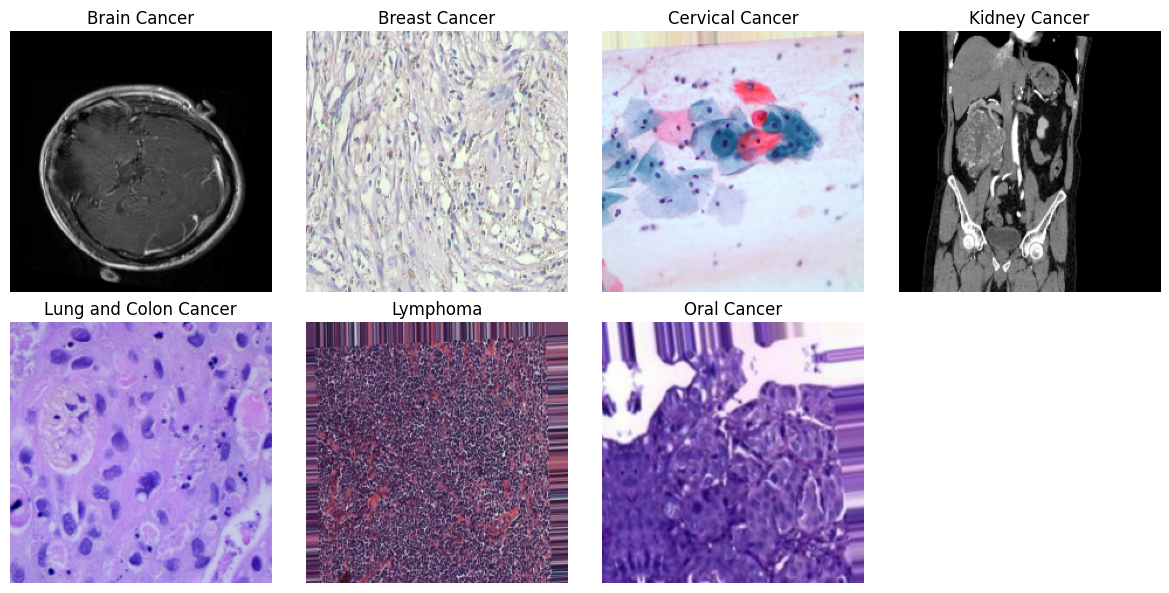

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import math

class_names = main_dataset_train.class_names

rep_images = {cls: None for cls in class_names}

# iterate until you’ve seen one image of each class
for batch in main_dataset_train.unbatch().batch(1):
    img, label = batch
    idx = np.argmax(label.numpy())
    cls = class_names[idx]
    if rep_images[cls] is None:
        rep_images[cls] = img[0].numpy().astype("uint8")
    if all(v is not None for v in rep_images.values()):
        break

n = len(class_names)
cols = 4
rows = math.ceil(n / cols)

plt.figure(figsize=(cols * 3, rows * 3))
for i, cls in enumerate(class_names):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(rep_images[cls])
    ax.set_title(cls)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [8]:
import os

root_path = directory

def list_subtypes(cancer_type):
    path = os.path.join(root_path, cancer_type)
    if os.path.exists(path):
        subtypes = sorted(os.listdir(path))
        print(f"{cancer_type} subtypes: {subtypes}")
    else:
        print(f"{cancer_type} folder not found.")

# Example usage
list_subtypes("Brain Cancer")
list_subtypes("Breast Cancer")
list_subtypes("Cervical Cancer")
list_subtypes("Lung and Colon Cancer")
list_subtypes("Lymphoma")
list_subtypes("Kidney Cancer")
list_subtypes("Oral Cancer")

Brain Cancer subtypes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Breast Cancer subtypes: ['breast_benign', 'breast_malignant']
Cervical Cancer subtypes: ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Lung and Colon Cancer subtypes: ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Lymphoma subtypes: ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Kidney Cancer subtypes: ['kidney_normal', 'kidney_tumor']
Oral Cancer subtypes: ['oral_normal', 'oral_scc']


In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample_images(cancer_type, n=3):
    path = os.path.join(root_path, cancer_type)
    subtypes = os.listdir(path)

    for subtype in subtypes:
        subtype_path = os.path.join(path, subtype)
        images = os.listdir(subtype_path)[:n]
        print(f"{subtype} sample images:")
        plt.figure(figsize=(10, 2))
        for i, img_name in enumerate(images):
            img_path = os.path.join(subtype_path, img_name)
            img = mpimg.imread(img_path)
            plt.subplot(1, n, i + 1)
            plt.imshow(img)
            plt.title(subtype)
            plt.axis("off")
        plt.show()

breast_malignant sample images:


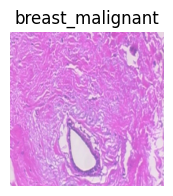

breast_benign sample images:


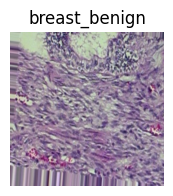

In [10]:
import os
root_path = directory  # Define if not already
show_sample_images("Breast Cancer", n=1)

In [11]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def create_model(num_classes):
    # Load the pre-trained MobileNetV3 model
    pre_model = MobileNetV3Large(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze the base model layers to use transfer learning
    pre_model.trainable = False

    # Add custom classification layers
    x = pre_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=pre_model.input, outputs=output_layer)

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    return model

In [12]:
def train_model(train_data, val_data, num_classes, model_name):
    model = create_model(num_classes)
    history = model.fit(train_data, validation_data=val_data, epochs=10)  # Store history
    model.save(f"{model_name}_model.keras")
    return history, model  # Return both history and model

In [24]:
def train_model_oral(train_data, val_data, num_classes, model_name):
    model = create_model(num_classes)
    history = model.fit(train_data, validation_data=val_data, epochs=15)  # Store history
    model.save(f"{model_name}_model.keras")
    return history, model  # Return both history and model

Training

In [ ]:
brain_dataset_train = data_loading("Brain Cancer", "training")
brain_dataset_val = data_loading("Brain Cancer", "validation")

num_classes_brain = 3
history, model = train_model(brain_dataset_train, brain_dataset_val, num_classes_brain, "brain_cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(brain_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Brain Cancer's training dataset
Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Brain Cancer's validation dataset
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 265s 344ms/step - accuracy: 0.8888 - loss: 0.3043 - val_accuracy: 0.9710 - val_loss: 0.0797
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 207s 273ms/step - accuracy: 0.9757 - loss: 0.0686 - val_accuracy: 0.9733 - val_loss: 0.0800
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 261s 273ms/step - accuracy: 0.9887 - loss: 0.0344 - val_accuracy: 0.9883 - val_loss: 0.0320
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 265s 277ms/step - accuracy: 0.9954 - loss: 0.0166 - val_accuracy: 0.9873 - val_loss: 0.0326
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 205s 273ms/step - accuracy: 0.9960 - loss: 0.0130 - val_accuracy: 0.9827 - val_loss: 0.0542
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 258s 269ms/step - accuracy: 0.9957

In [21]:
model.save("/workspaces/Cancer_Detection/new_models/models/brain_cancer_model.keras")

In [22]:
model = tf.keras.models.load_model("/workspaces/Cancer_Detection/new_models/models/brain_cancer_model.keras")

In [23]:
from functions import *

In [14]:
import matplotlib.pyplot as plt
def plot_class_distribution(dataset, title):
    class_counts = {}
    class_names = dataset.class_names  # Get class labels
    for images, labels in dataset:
        for label in labels.numpy():
            class_index = label.argmax()
            class_counts[class_names[class_index]] = class_counts.get(class_names[class_index], 0) + 1

    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

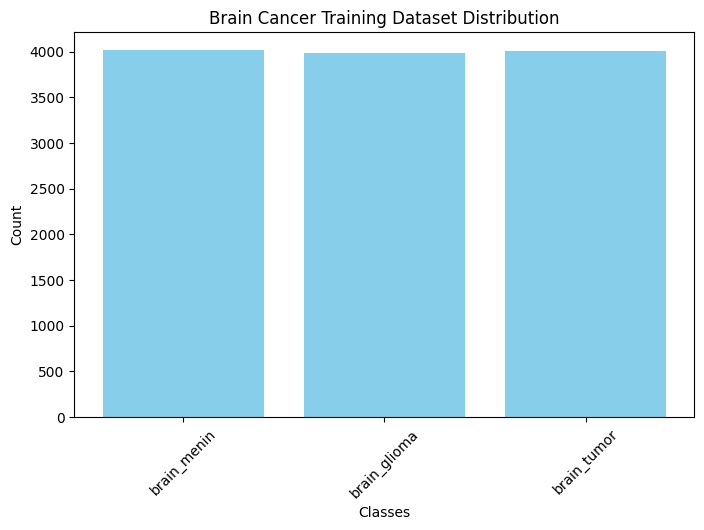

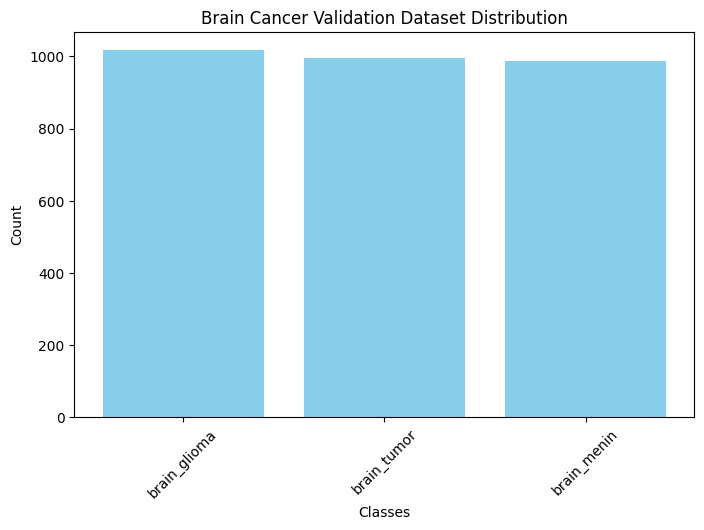

In [30]:
plot_class_distribution(brain_dataset_train, "Brain Cancer Training Dataset Distribution")
plot_class_distribution(brain_dataset_val, "Brain Cancer Validation Dataset Distribution")

In [15]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title("Model Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Model Loss")

    plt.show()

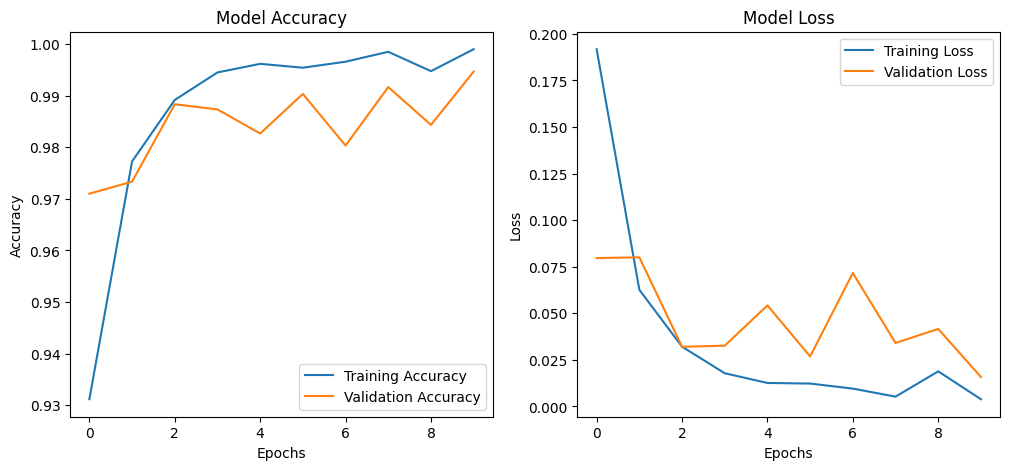

In [32]:
plot_training_history(history)

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataset, class_names):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(np.argmax(labels.numpy(), axis=1))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

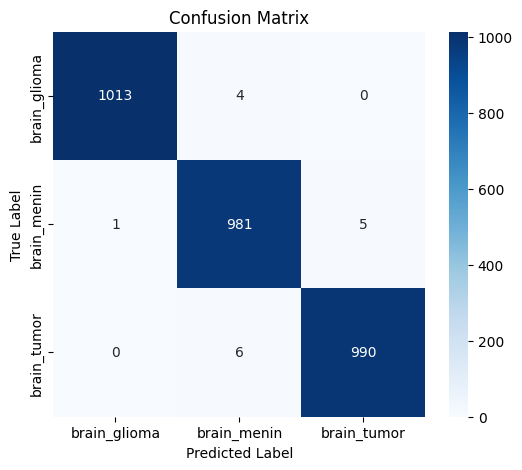

In [34]:
plot_confusion_matrix(model, brain_dataset_val, brain_dataset_val.class_names)

In [17]:
def plot_sample_predictions(model, dataset, class_names):
    images, labels = next(iter(dataset))
    predictions = model.predict(images)

    num_images = images.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(min(9, num_images)):  # Show up to 9 images, but not more than available
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = class_names[np.argmax(predictions[i])]
        true_label = class_names[np.argmax(labels[i].numpy())]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color="green" if pred_label == true_label else "red")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


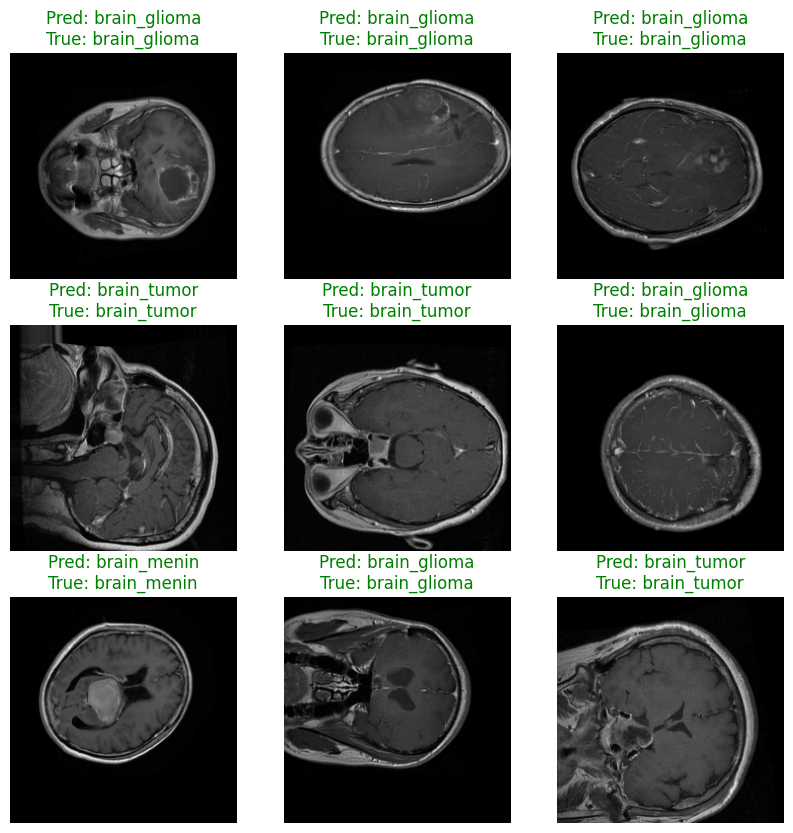

In [36]:
plot_sample_predictions(model, brain_dataset_val, brain_dataset_val.class_names)

In [18]:
import numpy as np
import cv2
import tensorflow as tf

def generate_gradcam_heatmap(model, image, class_index, last_conv_layer_name="conv_1_bn"):

    # Create a model that outputs the last conv layer and predictions
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    # Gradient of loss w.r.t. conv layer output
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)  # avoid div by zero
    heatmap = heatmap.numpy()

    # Resize heatmap to match input image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[2], image.shape[1]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Prepare original image for overlay
    img_display = image[0].numpy()
    if np.max(img_display) <= 1.0:
        img_display = np.uint8(255 * img_display)
    else:
        img_display = np.uint8(img_display)

    # If grayscale, convert to 3 channels
    if img_display.shape[-1] == 1:
        img_display = np.repeat(img_display, 3, axis=-1)

    # Convert to BGR for OpenCV overlay
    img_display_bgr = cv2.cvtColor(img_display, cv2.COLOR_RGB2BGR)

    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img_display_bgr, 0.6, heatmap_colored, 0.4, 0)

    # Display
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(img_display_bgr, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_resized, cmap='jet')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# Get a batch from your validation dataset
image_batch, label_batch = next(iter(brain_dataset_val))
image = image_batch[0]
label = label_batch[0]

# Add batch dimension
image_input = tf.expand_dims(image, axis=0)

# Predict the class
preds = model.predict(image_input)
predicted_class = tf.argmax(preds[0])

# Run Grad-CAM for the predicted class
generate_gradcam_heatmap(model, image_input, class_index=predicted_class)

SyntaxError: invalid syntax (1389173240.py, line 3)

In [45]:
breast_dataset_train = data_loading("Breast Cancer", "training")
breast_dataset_val = data_loading("Breast Cancer", "validation")

num_classes_breast = 2
history, model = train_model(breast_dataset_train, breast_dataset_val, num_classes_breast, "breast_cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(breast_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Breast Cancer's training dataset
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Breast Cancer's validation dataset
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 218s 426ms/step - accuracy: 0.9614 - loss: 0.1023 - val_accuracy: 0.9925 - val_loss: 0.0185
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 220s 341ms/step - accuracy: 0.9961 - loss: 0.0144 - val_accuracy: 0.9945 - val_loss: 0.0131
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 173s 346ms/step - accuracy: 0.9974 - loss: 0.0077 - val_accuracy: 0.9950 - val_loss: 0.0155
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 207s 355ms/step - accuracy: 1.0000 - loss: 7.9194e-04 - val_accuracy: 0.9965 - val_loss: 0.0105
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 200s 352ms/step - accuracy: 1.0000 - loss: 3.2526e-04 - val_accuracy: 0.9965 - val_loss: 0.0116
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 195s 338ms/step - accuracy: 1.0000 - loss: 1.0954e-04 - val_accuracy: 0.9970

In [46]:
model.save("/workspaces/Cancer_Detection/new_models/models/breast_cancer_model.keras")

In [51]:
cervix_dataset_train = data_loading("Cervical Cancer", "training")
cervix_dataset_val = data_loading("Cervical Cancer", "validation")

num_classes_cervix = 5
history, model = train_model(cervix_dataset_train, cervix_dataset_val, num_classes_cervix, "cervix_cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(cervix_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Cervical Cancer's training dataset


Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Cervical Cancer's validation dataset
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 410s 322ms/step - accuracy: 0.8958 - loss: 0.3218 - val_accuracy: 0.9868 - val_loss: 0.0374
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 396s 286ms/step - accuracy: 0.9963 - loss: 0.0158 - val_accuracy: 0.9888 - val_loss: 0.0261
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 396s 298ms/step - accuracy: 0.9959 - loss: 0.0138 - val_accuracy: 0.9984 - val_loss: 0.0049
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 373s 299ms/step - accuracy: 1.0000 - loss: 6.8691e-04 - val_accuracy: 0.9992 - val_loss: 0.0019
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 358s 286ms/step - accuracy: 1.0000 - loss: 1.3981e-04 - val_accuracy: 0.9994 - val_loss: 0.0014
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 358s 287ms/step - accuracy: 1.0000 - loss: 6.5911e-05 - val_accuracy: 0.9996 - val_loss: 0.001

In [52]:
model.save("/workspaces/Cancer_Detection/new_models/models/cervix_cancer_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


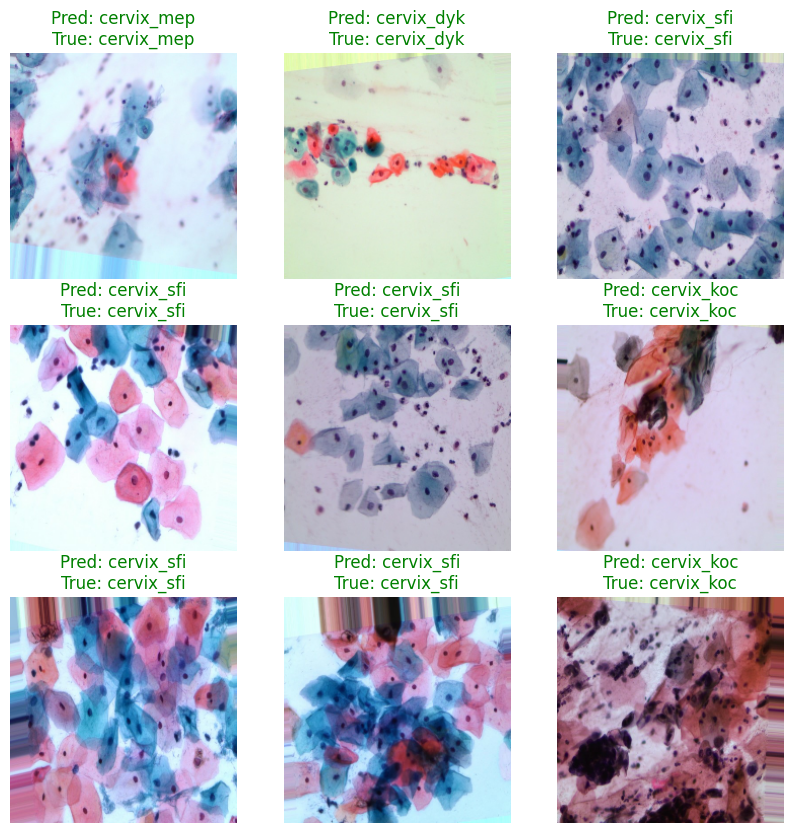

In [53]:
plot_sample_predictions(model, cervix_dataset_val, cervix_dataset_val.class_names)

In [55]:
kidney_dataset_train = data_loading("Kidney Cancer", "training")
kidney_dataset_val = data_loading("Kidney Cancer", "validation")

num_classes_kidney = 2
history, model = train_model(kidney_dataset_train, kidney_dataset_val, num_classes_kidney, "kidney_cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(kidney_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Kidney Cancer's training dataset
Found 10000 files belonging to 2 classes.
Using 8000 files for training.
Kidney Cancer's validation dataset
Found 10000 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 166s 320ms/step - accuracy: 0.9457 - loss: 0.1323 - val_accuracy: 0.9980 - val_loss: 0.0055
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 151s 302ms/step - accuracy: 0.9978 - loss: 0.0062 - val_accuracy: 0.9980 - val_loss: 0.0048
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 276ms/step - accuracy: 1.0000 - loss: 5.2473e-04 - val_accuracy: 1.0000 - val_loss: 7.1569e-04
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 274ms/step - accuracy: 1.0000 - loss: 1.1941e-04 - val_accuracy: 1.0000 - val_loss: 5.8428e-04
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 163s 325ms/step - accuracy: 1.0000 - loss: 6.7227e-05 - val_accuracy: 1.0000 - val_loss: 4.0028e-04
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 273ms/step - accuracy: 1.0000 - loss: 4.1155e-05 - val_

In [56]:
model.save("/workspaces/Cancer_Detection/new_models/models/kidney_cancer_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


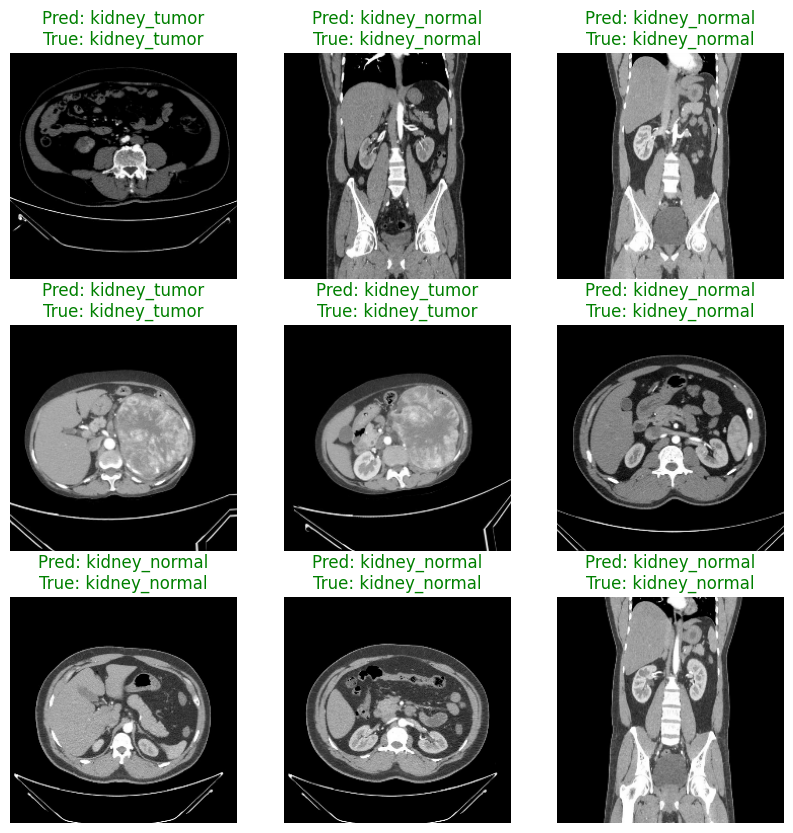

In [57]:
plot_sample_predictions(model, kidney_dataset_val, kidney_dataset_val.class_names)

In [58]:
lc_dataset_train = data_loading("Lung and Colon Cancer", "training")
lc_dataset_val = data_loading("Lung and Colon Cancer", "validation")

num_classes_lc = 5
history, model = train_model(lc_dataset_train, lc_dataset_val, num_classes_lc, "kidney_cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(lc_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Lung and Colon Cancer's training dataset
Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Lung and Colon Cancer's validation dataset
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.
Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 376s 296ms/step - accuracy: 0.9495 - loss: 0.1720 - val_accuracy: 0.9888 - val_loss: 0.0294
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 376s 301ms/step - accuracy: 0.9933 - loss: 0.0204 - val_accuracy: 0.9966 - val_loss: 0.0105
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 365s 292ms/step - accuracy: 0.9969 - loss: 0.0099 - val_accuracy: 0.9974 - val_loss: 0.0079
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 381s 291ms/step - accuracy: 0.9978 - loss: 0.0054 - val_accuracy: 0.9958 - val_loss: 0.0096
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 366s 293ms/step - accuracy: 0.9991 - loss: 0.0036 - val_accuracy: 0.9890 - val_loss: 0.0270
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 367s 293ms/step - accuracy: 0.9976 - loss: 0.0066 - val

In [59]:
model.save("/workspaces/Cancer_Detection/new_models/models/lung_colon_cancer_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


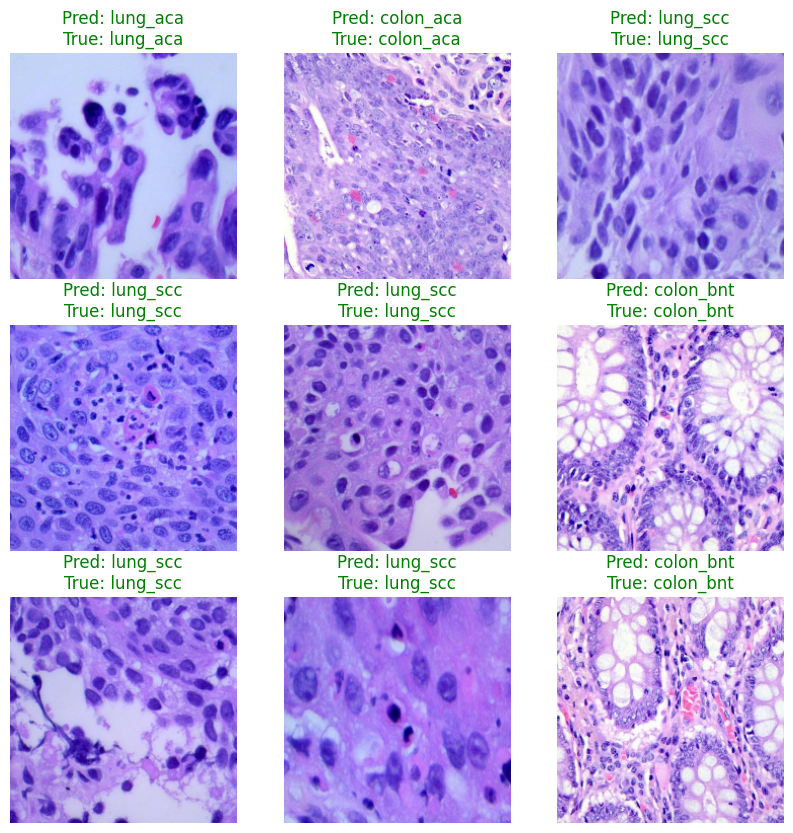

In [60]:
plot_sample_predictions(model, lc_dataset_val, lc_dataset_val.class_names)

In [23]:
Lymphoma_dataset_train = data_loading("Lymphoma", "training")
Lymphoma_dataset_val = data_loading("Lymphoma", "validation")

num_classes_lc = 3
history, model = train_model(Lymphoma_dataset_train, Lymphoma_dataset_val, num_classes_lc, "Lymphoma")

# Now you can evaluate the model
loss, accuracy = model.evaluate(Lymphoma_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Lymphoma's training dataset
Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Lymphoma's validation dataset
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 151s 196ms/step - accuracy: 0.7190 - loss: 0.6388 - val_accuracy: 0.8673 - val_loss: 0.3162
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 199s 193ms/step - accuracy: 0.9294 - loss: 0.1987 - val_accuracy: 0.9550 - val_loss: 0.1300
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 144s 192ms/step - accuracy: 0.9613 - loss: 0.1080 - val_accuracy: 0.9567 - val_loss: 0.1111
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 146s 195ms/step - accuracy: 0.9796 - loss: 0.0604 - val_accuracy: 0.9710 - val_loss: 0.0796
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 143s 191ms/step - accuracy: 0.9899 - loss: 0.0361 - val_accuracy: 0.9760 - val_loss: 0.0638
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 147s 195ms/step - accuracy: 0.9942 - loss: 0.0231 - val_accuracy: 0.9763 - val_loss: 0.0646
E

In [25]:
model.save("/workspaces/Cancer_Detection/new_models/models/lymphoma_cancer_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


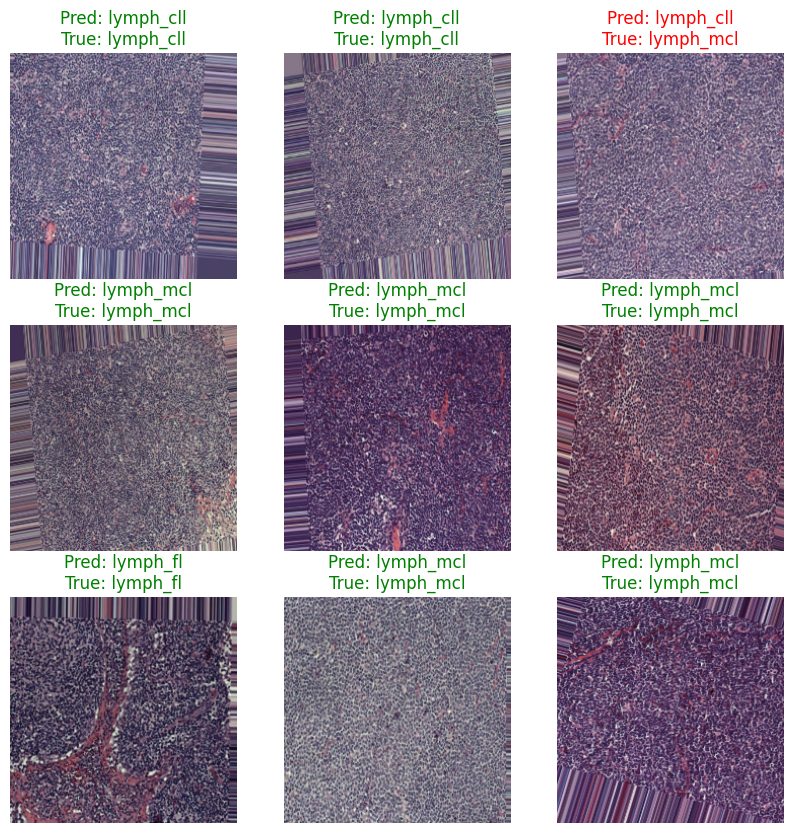

In [26]:
plot_sample_predictions(model, Lymphoma_dataset_val, Lymphoma_dataset_val.class_names)

In [29]:
Oral_dataset_train = data_loading("Oral Cancer", "training")
Oral_dataset_val = data_loading("Oral Cancer", "validation")

num_classes_Oral = 2
history, model = train_model_oral(Oral_dataset_train, Oral_dataset_val, num_classes_Oral, "Oral Cancer")

# Now you can evaluate the model
loss, accuracy = model.evaluate(Oral_dataset_val)
print(f"Evaluation Results - Loss: {loss}, Accuracy: {accuracy}")

Oral Cancer's training dataset
Found 10002 files belonging to 2 classes.
Using 8002 files for training.
Oral Cancer's validation dataset
Found 10002 files belonging to 2 classes.
Using 2000 files for validation.
Epoch 1/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 129s 248ms/step - accuracy: 0.7795 - loss: 0.4358 - val_accuracy: 0.8740 - val_loss: 0.2958
Epoch 2/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.9129 - loss: 0.2049 - val_accuracy: 0.9055 - val_loss: 0.2315
Epoch 3/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 97s 193ms/step - accuracy: 0.9509 - loss: 0.1226 - val_accuracy: 0.9245 - val_loss: 0.2033
Epoch 4/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 142s 193ms/step - accuracy: 0.9774 - loss: 0.0739 - val_accuracy: 0.9370 - val_loss: 0.1832
Epoch 5/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 96s 191ms/step - accuracy: 0.9854 - loss: 0.0460 - val_accuracy: 0.9440 - val_loss: 0.1915
Epoch 6/15
501/501 ━━━━━━━━━━━━━━━━━━━━ 97s 194ms/step - accuracy: 0.9952 - loss: 0.0203 - val_accuracy: 0.9465 - val_loss: 0.1738


In [30]:
model.save("/workspaces/Cancer_Detection/new_models/models/oral_cancer_model.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


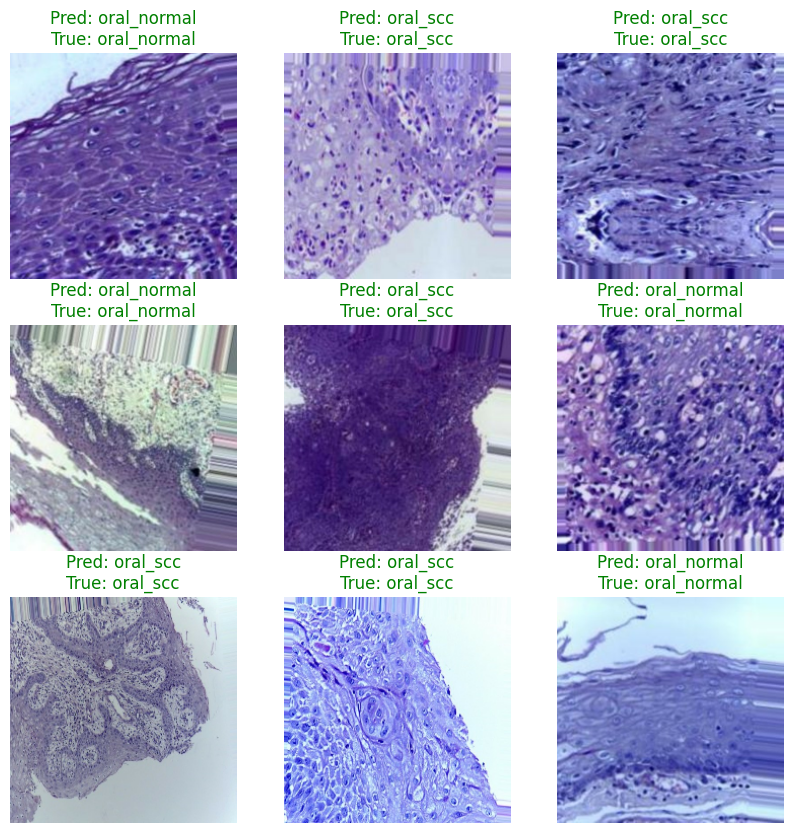

In [32]:
plot_sample_predictions(model, Oral_dataset_val, Oral_dataset_val.class_names)

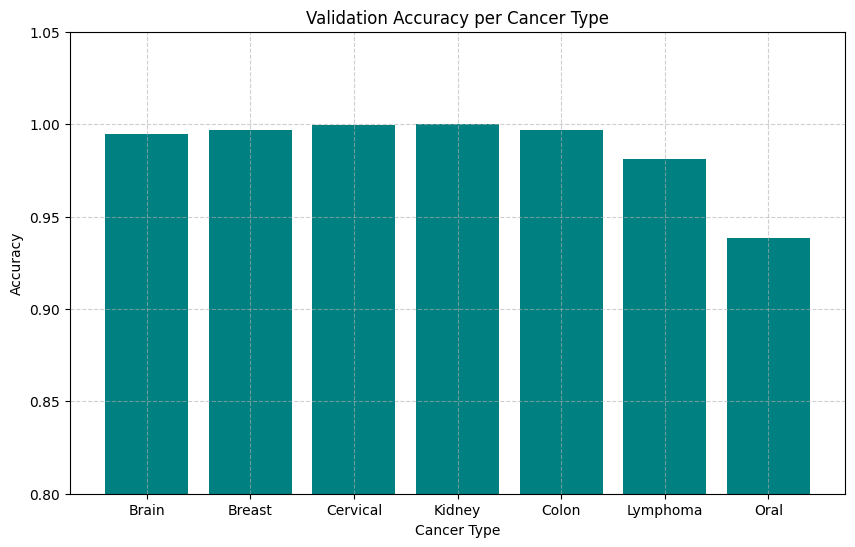

In [35]:
import matplotlib.pyplot as plt

cancer_types = ['Brain', 'Breast', 'Cervical', 'Kidney', 'Colon', 'Lymphoma', 'Oral']
accuracies = [ 0.9947, 0.9970,  0.9995, 0.9999, 0.9970, 0.9810, 0.9385]

plt.figure(figsize=(10, 6))
plt.bar(cancer_types, accuracies, color='teal')
plt.ylim(0.8, 1.05)
plt.title("Validation Accuracy per Cancer Type")
plt.ylabel("Accuracy")
plt.xlabel("Cancer Type")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()